# Premier pas vers l’industrialisation avec les pipelines scikit

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/6_pipeline.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/6_pipeline.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/6_pipeline.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/modelisation%206_pipeline.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=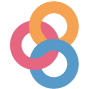" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/6_pipeline.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/modelisation/6_pipeline.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

# Pourquoi utiliser les pipelines ?

Les chapitres précédents ont permis de montrer des bouts de code
épars pour entraîner des modèles ou faire du *preprocessing*.
Cette démarche est intéressante pour tâtonner mais risque d’être coûteuse
ultérieurement s’il est nécessaire d’ajouter une étape de preprocessing
ou de changer d’algorithme.

Heureusement, `scikit` propose un excellent outil pour proposer un cadre
général pour créer une chaîne de production *machine learning*. Il
s’agit des
[*pipelines*](https://scikit-learn.org/stable/modules/compose.html).
Ils présentent de nombreux intérêts, parmi lesquels:

-   Ils sont très **pratiques** et **lisibles**. On rentre des données en entrée, on n’appelle qu’une seule fois les méthodes `fit` et `predict` ce qui permet de s’assurer une gestion cohérente des transformations de variables, par exemple après l’appel d’un `StandardScaler`
-   La **modularité** rend aisée la mise à jour d’un pipeline et renforce la capacité à le réutiliser
-   Ils permettent de facilement chercher les hyperparamètres d’un modèle. Sans *pipeline*, écrire un code qui fait du *tuning* d’hyperparamètres peut être pénible. Avec les *pipelines*, c’est une ligne de code.
-   La **sécurité** d’être certain que les étapes de preprocessing sont bien appliquées aux jeux de données désirés avant l’estimation.

{{% box status=“hint” title=“Hint” icon=“fa fa-lightbulb” %}}
Un des intérêts des *pipelines* scikit est qu’ils fonctionnent aussi avec
des méthodes qui ne sont pas issues de `scikit`.

Il est très
facile d’introduire un modèle de réseau de neurone `Keras` dans
un pipeline `scikit`.

Pour introduire un modèle économétrique `statsmodels`
c’est un peu plus coûteux mais nous allons proposer des exemples
qui peuvent servir de modèle et qui montrent que c’est faisable
sans trop de difficulté.
{{% /box %}}

{{% box status=“warning” title=“Warning” icon=“fa fa-exclamation-triangle” %}}

Les éléments présents dans ce chapitre nécessitent une version assez récente
de `scikit` (au moins la version 1.0). Pour vérifier la version, faire:

In [2]:
import sklearn
print(sklearn.__version__)

Il faut également une version récente de `yellowbrick` pour éviter l’erreur
suivante quand on utilise une version récente de `scikit` (ce que
je recommande):

> `ImportError: cannot import name 'safe_indexing' from 'sklearn.utils'`

{{% /box %}}

# Comment créer un *pipeline*

Un *pipeline* est un enchaînement d’opérations qu’on code en enchainant
des pairs *(clé, valeur)*:

-   la clé est le nom du pipeline, cela peut être utile lorsqu’on va
    représenter le *pipeline* sous forme de diagramme acyclique (visualisation DAG)
    ou qu’on veut afficher des informations sur une étape
-   la valeur représente la transformation à mettre en oeuvre dans le *pipeline*
    (c’est-à-dire, à l’exception de la dernière étape,
    mettre en oeuvre une méthode `transform` et éventuellement une
    transformation inverse).

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA

estimators = [('reduce_dim', PCA()), ('clf', SVC())]
pipe = Pipeline(estimators)

{{% box status=“hint” title=“Hint” icon=“fa fa-lightbulb” %}}

Il est pratique de visualiser un *pipeline* sous forme de DAG.
Pour cela, dans un notebook, on utilise la configuration
suivante:

``` python
#| eval: false
from sklearn import set_config
set_config(display='diagram') 
```

{{% /box %}}

``` python
pipe
```

{{< rawhtml >}}

{{< /rawhtml >}}

Au sein d’une étape de *pipeline*, les paramètres d’un estimateur
sont accessibles avec la notation `<estimator>__<parameter>`.
Cela permet de fixer des valeurs pour les arguments des fonctions `scikit`
qui sont appelées au sein d’un *pipeline*.
C’est cela qui rendra l’approche des pipelines particulièrement utile
pour la *grid search*:

In [6]:
from sklearn.model_selection import GridSearchCV
param_grid = {"reduce_dim__n_components":[2, 5, 10], "clf__C":[0.1, 10, 100]}
grid_search = GridSearchCV(pipe, param_grid=param_grid)

{{< rawhtml >}}

{{< /rawhtml >}}

## Données utilisées

Nous allons utiliser les données de transactions immobilières DVF pour chercher
la meilleure manière de prédire, sachant les caractéristiques d’un bien, son
prix.

Ces données peuvent être importées directement depuis [`data.gouv`](https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/):

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mutations = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2', sep = "|", decimal=",")

On propose d’enrichir la base de quelques variables qui pourraient servir
ultérieurement:

In [9]:
mutations['Date mutation'] = pd.to_datetime(mutations['Date mutation'], format = "%d/%m/%Y")
mutations['year'] = mutations['Date mutation'].dt.year
mutations['month'] = mutations['Date mutation'].dt.month
mutations['dep'] = mutations['Code postal'].astype(str).str[:2]
mutations['lprix'] = np.log(mutations["Valeur fonciere"])

Si vous travaillez avec les données de 2020, n’oubliez pas
d’intégrer l’effet
confinement strict dans vos modèles. Pour cela, vous pouvez créer une variable
indicatrice entre les dates en question:

In [10]:
mutations['confinement'] = mutations['Date mutation'].between(pd.to_datetime("2020-03-17"), pd.to_datetime("2020-05-03")).astype(int)

Les données DVF proposent une observation par transaction. Ces transactions
peuvent concerner plusieurs lots.
Pour simplifier,
on va créer une variable de surface qui agrège les différentes informations
de surface disponibles dans le jeu de données. En effet, les variables
en question sont très corrélées les unes entre elles :

In [12]:
g.figure.get_figure()

Les agréger revient à supposer que le modèle de fixation des prix est le même
entre chaque lot. C’est une hypothèse simplificatrice qu’une personne plus
experte du marché immobilier, ou qu’une approche propre de sélection
de variable pourrait amener à nier

In [13]:
mutations['surface'] = mutations.loc[:, mutations.columns[mutations.columns.str.startswith('Surface Carrez')].tolist()].sum(axis = 1)

# Un premier pipeline: *random forest* sur des variables standardisées

Notre premier *pipeline* va nous permettre d’intégrer ensemble:

1.  Une étape de *preprocessing* avec la standardisation de variables
2.  Une étape d’estimation du prix en utilisant un modèle de *random forest*

Pour le moment, on va prendre comme acquis un certain nombre de variables
explicatives (les *features*) et les hyperparamètres du modèle

## Définition des ensembles train/test

Nous allons donc nous restreindre à un sous-ensemble de colonnes dans un
premier temps :

In [14]:
xvars = ['dep', 'Nombre de lots', 'Code type local', 'surface', 'Nombre pieces principales']
xvars2 = pd.Series(xvars).str.replace(" ","_").tolist()

mutations2 = mutations.loc[:, xvars + ["Valeur fonciere"]]

Nous allons également ne conserver que les transactions inférieures à 5 millions
d’euros (on anticipe que celles ayant un montant supérieur sont des transactions
exceptionnelles dont le mécanisme de fixation du prix diffère)

In [15]:
mutations2  = mutations2.dropna()
mutations2 = mutations2.loc[mutations2['Valeur fonciere'] < 5e6] #keep only values below 10 millions

mutations2.columns = mutations2.columns.str.replace(" ", "_")
numeric_features = mutations2.columns[~mutations2.columns.isin(['dep','Code_type_local', 'confinement'])].tolist()
categorical_features = ['dep','Code_type_local']

Au passage, nous avons abandonné la variable de code postal pour privilégier
la commune afin de réduire la dimension de notre jeu de données. Si on voulait
vraiment avoir un bon modèle, il faudrait faire autrement car le code postal
est probablement un très bon prédicteur du prix d’un bien, une fois que
les caractéristiques du bien sont contrôlées.

Nous allons stratifier notre échantillonage de train/test par département
afin de tenir compte, de manière minimale, de la géographie.
Pour accélérer les calculs pour ce tutoriel, nous n’allons considérer que
20% des transactions observées sur chaque département.

In [16]:
from sklearn.model_selection import train_test_split

mutations2 = mutations2.groupby('dep').sample(frac = 0.2, random_state = 123)

X_train, X_test, y_train, y_test = train_test_split(mutations2[xvars2], mutations2[["Valeur_fonciere"]].values.ravel(), test_size = 0.2, random_state = 0, stratify=mutations2[['dep']])

## Définition du premier pipeline

Nous allons donc partir d’un *random forest* avec des valeurs d’hyperparamètres
données.

Les *random forest* sont une méthode d’aggrégation[1] d’arbres de décision.
On calcule $K$ arbres de décision et en tire, par une méthode d’agrégation,
une règle de décision moyenne qu’on va appliquer pour tirer une
prédiction de nos données.

![](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)

C’est un article de Léo Breiman (2001)[2], statisticien à Berkeley, qui
est à l’origine du succès des *random forests*. L’un des intérêts
des *random forest* est qu’il existe des méthodes pour déterminer
l’importance relative de chaque variable dans la prédiction.

Pour commencer, nous allons fixer la taille des arbres de décision avec
l’hyperparamètre `max_depth = 2`.

[1] En *machine learning* on retrouve un principe inspiré du
*bootstrap*
qui permet d’agréger un ensemble d’estimateurs en un estimateur *“moyennisé”*.
Il s’agit du [*bagging*](https://en.wikipedia.org/wiki/Bootstrap_aggregating).
En économétrie, le *bootstrap* consiste à ré-estimer sur *K* sous-échantillons
aléatoires des données un estimateur afin d’en tirer, par exemple, un intervalle
de confiance empirique à 95%. Le principe du *bagging* est le même. On ré-estime
*K* fois notre estimateur (par exemple un arbre de décision) et propose une
règle d’agrégation pour en tirer une règle moyennisée et donc une prédiction.

[2] Extrait de [ce blog](https://mljar.com/blog/feature-importance-in-random-forest/):
Gini importance (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance.

In [17]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=123)

Notre *pipeline* va intégrer les étapes suivantes:

1.  **Preprocessing**:
    -   Les variables numériques vont être standardisées avec un `StandardScaler`.
        Pour cela, nous allons utiliser la liste `numeric_features` définie précédemment.
    -   Les variables catégorielles vont être explosées avec un *one hot encoding*
        (méthode `OneHotEncoder` de `scikit`)
        Pour cela, nous allons utiliser la liste `categorical_features`
2.  **Random forest**: nous allons appliquer l’estimateur `regr` défini plus haut

J’ajoute en commentaire un exemple de comment s’introduirait une imputation
de valeurs manquantes. La version 1.0 de `scikit` facilite l’intégration
d’étapes complexes dans les pipelines[1]. Si vous utilisez une
version antérieure à la 1.0 de `scikit`, vous pouvez vous rendre dans
la section [Annexe](#annexe) pour avoir des exemples de définition alternative
(attention cependant, vous ne pourrez récupérer le nom des *features*
transformées comme ici, ce qui peut pénaliser l’analyse d’importance
de variables)

[1] Voir ce [*thread stackoverflow*](https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer)

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

numeric_pipeline = make_pipeline(
  #SimpleImputer(),
  StandardScaler()
)
transformer = make_column_transformer(
    (numeric_pipeline, numeric_features[:-1]),
    (OneHotEncoder(sparse = False, handle_unknown = "ignore"), categorical_features))
pipe = Pipeline(steps=[('preprocessor', transformer),
                      ('randomforest', regr)])

Nous avons construit ce pipeline sous forme de couches successives. La couche
`randomforest` prendra automatiquement le résultat de la couche `preprocessor`
en *input*. La couche `features` permet d’introduire de manière relativement
simple (quand on a les bonnes méthodes) la complexité du *preprocessing*
sur données réelles dont les types divergent.

On peut visualiser le graphe et ainsi se représenter la manière dont
ce *pipeline* opère:

``` python
pipe
```

{{< rawhtml >}}

{{< /rawhtml >}}

Maintenant, il ne reste plus qu’à estimer notre modèle sur l’ensemble
d’entraînement. C’est très simple avec un *pipeline* : il suffit d’utiliser
de mettre à jour le *pipeline* avec la méthode `fit`

On peut utiliser le nom du pipeline en conjonction de certaines méthodes
pour appliquer cette étape sur un jeu de données pour visualiser
l’effet de la transformation.

Par exemple, pour visualiser le jeu de données transformé avant l’étape
d’estimation, on peut
faire

In [21]:
pipe[:-1].fit_transform(X_train)

De même, si on veut récupérer le nom des *features* en sortie du preprocessing,
on utilisera la méthode `.get_feature_names_out` qui est bien pratique
(c’est cette méthode qui est plus complexe à appeler dans les versions `scikit`
ancienne qui nous a fait privilégier le *pipeline* ci-dessous)

In [22]:
features_names=pipe['preprocessor'].get_feature_names_out()
features_names

## *Variable importance*

On ne va représenter, parmi notre ensemble important de colonnes, que celles
qui ont une importance non nulle. Grâce à notre vecteur `features_names`,
on va pouvoir facilement afficher le nom des colonnes en question (et donc
comprendre les *features* déterminantes)

L’importance va être définie à partir
de la mesure d’impureté[1]

On voit donc que deux variables déterminantes sont des effets fixes
géographiques (qui servent à ajuster de la différence de prix entre
Paris et les Hauts de Seine et le reste de la France), une autre variable
est un effet fixe type de bien. Les deux variables qui pourraient introduire
de la variabilité, à savoir la surface et, dans une moindre mesure, le
nombre de lots, ont une importance moindre.

{{% box status=“note” title=“Note” icon=“fa fa-comment” %}}
Idéalement, on utiliserait `yellowbrick` pour représenter l’importance des variables
Mais en l’état actuel du *pipeline* on a beaucoup de variables dont le poids
est nul qui viennent polluer la visualisation. Vous pouvez
consulter la
[documentation de `yellowbrick` sur ce sujet](https://www.scikit-yb.org/en/latest/api/model_selection/importances.html)
{{% /box %}}

## Prédiction

L’analyse de l’importance de variables permet de mieux comprendre
le fonctionnement interne des *random forests*.

On obtient un modèle dont les performances sont les suivantes:

[1] Extrait de [ce blog](https://mljar.com/blog/feature-importance-in-random-forest/):
Gini importance (or mean decrease impurity), which is computed from the Random Forest structure. Let’s look how the Random Forest is constructed. It is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance.

In [25]:
from sklearn.metrics import mean_squared_error


compar = pd.DataFrame([y_test, pipe.predict(X_test)]).T
compar.columns = ['obs','pred']
compar['diff'] = compar.obs - compar.pred

print("Le RMSE sur le jeu de test est {:,}".format(
   int(np.sqrt(mean_squared_error(y_test, pipe.predict(X_test))))
))

Le RMSE n’est pas très bon. Pour comprendre pourquoi, représentons
notre nuage de point des valeurs observées et prédites:

C’est très décevant. La prédiction a trop peu de variabilité pour capturer
la variance des prix observée. Cela vient du fait que les variables
ayant de l’importance dans la prédiction sont principalement des effets fixes,
qui ne permettent donc qu’une variabilité limitée.

In [27]:
g.figure.get_figure()

# Recherche des hyperparamètres optimaux avec une validation croisée

On détecte que le premier modèle n’est pas très bon et ne nous aidera
pas vraiment à évaluer de manière fiable la maison de nos rêves.

On va essayer de voir si notre modèle ne serait pas meilleur avec des
hyperparamètres plus adaptés. Après tout, nous avons choisi par défaut
la profondeur de l’arbre mais c’était un choix au doigt mouillé.

Quels sont les hyperparamètres qu’on peut essayer d’optimiser ?

In [28]:
pipe['randomforest'].get_params()

Un [détour par la documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
nous aide à comprendre ceux sur lesquels on va jouer. Par exemple, il serait
absurde de jouer sur le paramètre `random_state` qui est la racine du générateur
pseudo-aléatoire.

Comme l’objectif est de se concentrer sur la démarche plus qu’essayer de
trouver un bon modèle,
nous allons également réduire la taille des données pour accélérer
les calculs

In [29]:
mutations2 = mutations2.groupby('dep').sample(frac = 0.5, random_state = 123)

X_train, X_test, y_train, y_test = train_test_split(mutations2[xvars2], mutations2[["Valeur_fonciere"]].values.ravel(), test_size = 0.2, random_state = 0, stratify=mutations2[['dep']])

X = pd.concat((X_train, X_test), axis=0)
Y = np.concatenate([y_train,y_test])

Nous allons nous contenter de jouer sur les paramètres:

-   `n_estimators`: Le nombre d’arbres de décision que notre forêt contient
-   `max_depth`: La profondeur de chaque arbre

Il existe plusieurs manières de faire de la validation croisée. Nous allons ici
utiliser la *grid search* qui consiste à estimer et tester le modèle sur chaque
combinaison d’une grille de paramètres et sélectionner le couple de valeurs
des hyperparamètres amenant à la meilleure prédiction. Par défaut, `scikit`
effectue une *5-fold cross validation*. Nous n’allons pas changer
ce comportement.

Comme expliqué précédemment, les paramètres s’appelent sous la forme
`<step>__<parameter_name>`

La validation croisée pouvant être très consommatrice de temps, nous
n’allons l’effectuer que sur un nombre réduit de valeurs de notre grille.
Il est possible de passer la liste des valeurs à passer au crible sous
forme de liste (comme pour l’argument `max_depth` ci-dessous) ou
sous forme d’`array` (comme pour l’argument `n_estimators`) ce qui est
souvent pratique pour générer un criblage d’un intervalle avec `np.linspace`.

{{< rawhtml >}}

{{< /rawhtml >}}

On peut récupérer les paramètres optimaux avec la méthode `best_params_`:

In [33]:
grid_search.best_params_

On pourra aussi ré-utiliser le modèle optimal de la manière suivante:

``` python
grid_search.best_estimator_
```

{{< rawhtml >}}

{{< /rawhtml >}}

Toutes les performances sur les ensembles d’échantillons et de test sur la grille
d’hyperparamètres sont disponibles dans l’attribut:

In [35]:
perf_random_forest = pd.DataFrame(grid_search.cv_results_)

Regardons les résultats moyens pour chaque valeur des hyperparamètres:

Globalement, à profondeur d’arbre donnée, le nombre d’arbres change
marginalement la performance (cela détériore
la performance quand la profondeur est de 4, cela améliore quand
on fixe la profondeur de 2).
En revanche, changer la profondeur de l’arbre améliore la
performance de manière plus marquée.

Maintenant, il nous reste à re-entraîner le modèle avec ces nouveaux
paramètres sur l’ensemble du jeu de *train* et l’évaluer sur l’ensemble
du jeu de *test*:

On obtient le RMSE suivant:

In [39]:
print("Le RMSE sur le jeu de test est {:,}".format(
   int(np.sqrt(mean_squared_error(y_test, pipe_optimal.predict(X_test))))
))

Et si on regarde la qualité en prédiction:

In [41]:
g.figure.get_figure()

On obtient plus de variance dans la prédiction, c’est déjà un peu mieux.
Cependant, cela reste décevant pour plusieurs raisons:

-   nous n’avons pas fait d’étape de sélection de variable
-   nous n’avons pas chercher à déterminer si la variable à prédire la plus
    pertinente était le prix ou une transformation de celle-ci
    (par exemple le prix au $m^2$)

In [42]:
features_names=pipe_optimal['preprocessor'].get_feature_names_out()
importances = pipe_optimal['randomforest'].feature_importances_
std = np.std([tree.feature_importances_ for tree in pipe_optimal['randomforest'].estimators_], axis=0)

forest_importances = pd.Series(importances[importances>0], index=features_names[importances>0])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std[importances>0], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Remarque sur la performance

Les estimations sont, par défaut, menées de manière séquentielle (l’une après
l’autre). Nous sommes cependant face à un problème
*embarassingly parallel*.
Pour gagner en performance, il est recommandé d’utiliser l’argument
`n_jobs=-1`.

## Remarque sur l’échantillonnage

En l’état actuel de l’échantillonnage entre train et test au sein de la
*grid search*,
on est face à un problème de *data leaking* car l’échantillon
n’est pas balancé entre nos classes (les départements).

Certaines classes se
retrouvent hors de l’échantillon d’estimation mais dans l’échantillon de prédiction.
Autrement dit, notre *pipeline* de *preprocessing* se retrouve à devoir
nettoyer des valeurs qu’il ne connaît pas.

Nous avons choisi une option, dans notre *pipeline* pour se faciliter la vie
à ce propos. Nous ne rencontrons pas d’erreur car nous avons utilisé l’option
`handle_unknown = "ignore"` plutôt que
`handle_unknown = "error"` (défaut) dans le *one hot encoding*.
Cette option est dangereuse et n’est pas recommandée pour un vrai *pipeline*.
De manière générale, il vaut mieux adopter une approche de
programmation défensive en n’hésitant pas à renvoyer une erreur si la
structure du *DataFrame* de prédiction diffère vraiment de celle du *DataFrame*
d’entraînement.

Pour éviter cette erreur, il serait mieux de définir explicitement le schéma de
validation croisée à mettre en oeuvre.
Précédemment, nous avions utilisé un échantillonnage stratifié.
Cela pourrait être fait ici avec
la méthode `StratifiedGroupKFold` (plus d’éléments à venir)

``` python
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=5)
#grid_search.fit(pd.concat((X_train, X_test), axis=0), np.concatenate([y_train,y_test]), cv = cv, groups = pd.concat((X_train, X_test), axis=0)['dep'])
```

# Eléments supplémentaires à venir

Ce chapitre est amené à être enrichi des éléments suivants
(cf. [#207](https://github.com/linogaliana/python-datascientist/issues/207))

-   [ ] Comparaison performance entre modèles grâce aux pipelines
-   [ ] Intégration d’une étape de sélection de variable dans un pipeline
-   [ ] `statsmodels` dans un pipeline
-   [ ] `Keras` dans un pipeline

# Annexes: pipelines alternatifs

## Préalable : quelques méthodes pour gagner en flexibilité dans le preprocessing

Notre *DataFrame* comporte des types hétérogènes de variables:

-   Des variables numériques dont les variances sont très hétérogènes
-   Des variables textuelles qui mériteraient un recodage sous forme numérique
-   Des variables discrètes dont les modalités devraient être éclatées (*one hot encoding*)

Pour gagner en flexibilité, nous allons proposer certaines méthodes qui permettent
d’appliquer les étapes de *preprocessing* adéquates à un sous-ensemble de
variables[1]. Ces méthodes ne sont plus nécessaires dans les versions
récentes de `scikit`.

Pour cela, il convient d’adopter l’approche de la programmation orientée objet.
On va créer des classes avec des méthodes `transform` et `fit_transform`
qui pourront ainsi être intégrées directement dans les *pipelines*, comme s’il
s’agissait de méthodes issues de `scikit`.

La première généralise `LabelEncoder` à un sous-ensemble de colonnes:

[1] Un certain nombre des éléments suivants ont été glannés, par ci par là,
depuis `stackoverflow`.

In [44]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

La seconde généralise cette fois le *one hot encoding* à un sous ensemble de
fonctions

In [45]:
class MultiColumnOneHotEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = OneHotEncoder(sparse=False).fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = OneHotEncoder(sparse=False).fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

Les méthodes suivantes vont nous permettre de passer en arguments les noms
de colonnes pour intégrer la récupération des bonnes colonnes de nos
dataframes dans le pipeline:

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

class Normalize(BaseEstimator, TransformerMixin):
    def __init__(self, func=None, func_param={}):
        self.func = func
        self.func_param = func_param

    def transform(self, X):
        if self.func != None:
            return self.func(X, **self.func_param)
        else:
            return X

    def fit(self, X, y=None, **fit_params):
        return self

Enfin, on va créer une méthode intermédiaire sous forme de *hack*
(elle prend une matrice en entrée et renvoie la même matrice)
pour
pouvoir facilement récupérer notre matrice de *feature* afin de vérifier
ses caractéristiques (notamment le nombre de colonnes disponibles):

In [47]:
class Collect(BaseEstimator, TransformerMixin):

    def transform(self, X):
        #print(X.shape)
        #self.shape = shape
        # what other output you want
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [48]:
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

pipe2 = Pipeline([
    ("features", FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric_features[:-1]),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical_features),OneHotEncoder(sparse=False)))
    ])),
    ('identity', Collect()),
    ('randomforest', regr)
])

{{< rawhtml >}}

{{< /rawhtml >}}

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numeric_features[:-1]),
        ('categorical', OneHotEncoder(sparse=False, handle_unknown = "ignore"), categorical_features)])

pipe3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('randomforest', regr)])

{{< rawhtml >}}

{{< /rawhtml >}}

# Références

-   Breiman L (2001). *“Random Forests”. Machine Learning*. 45 (1): 5–32.